In [1]:
import os
import cv2
import sys
import ujson
import numpy as np
from tqdm import tqdm
from skimage.transform import rotate
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True, precision=4)

# project file imports
from config import GlobalConfig
from utils import get_vehicle_to_virtual_lidar_transform, \
      get_vehicle_to_lidar_transform, get_lidar_to_vehicle_transform, get_lidar_to_bevimage_transform

## CARLA dataset

In [2]:
from data import CARLA_Data, crop_image_cv2
root_dir = '/home/surya/Downloads/transfuser-2022/data/'
config = GlobalConfig(root_dir=root_dir, setting='all')
train_set = CARLA_Data(root=config.train_data, config=config)
print(f"There are {len(train_set)} samples in training set")

# we'll look at data points within 1 sample
index = 0

100%|██████████| 11/11 [00:01<00:00,  7.69it/s]
Loading 16088 lidars from 11 folders
There are 16088 samples in training set


### RGB image

(160, 960, 3)


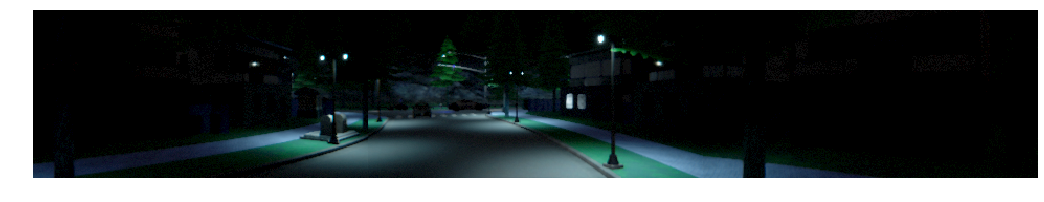

In [3]:
# load RGB image, scale to resolution, change to (C, H, W) format
rgb_image = cv2.imread(str(train_set.images[index], encoding='utf-8'), cv2.IMREAD_COLOR)
print(rgb_image.shape)

plt.figure(figsize=(18, 8))
plt.imshow(rgb_image);
plt.axis('off');

### BEV image

bev_array shape = (500, 500, 3), Unique values are [  0 128 192]
Decoded bev shape = (2, 500, 500)
Cropped bev shape = (160, 160), unique values = [0 1 2], dtype = int64


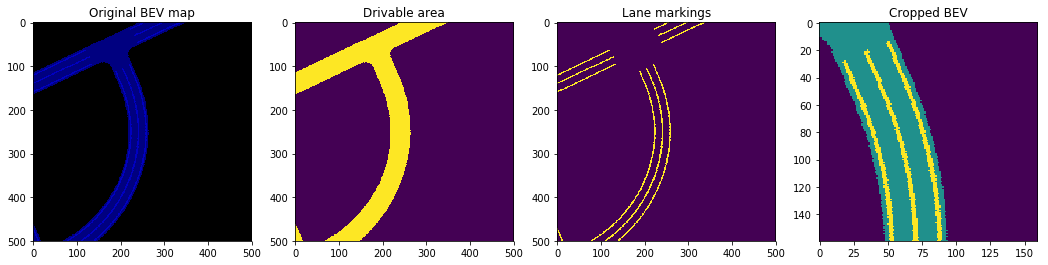

In [4]:
# BEV image -> load, decode, crop
# BEV image is multi class map containing 3 classes
# drivable area, lane markings, unkown (black)
bev_array = cv2.imread(str(train_set.bevs[index], encoding='utf-8'), cv2.IMREAD_UNCHANGED)
bev_array = cv2.cvtColor(bev_array, cv2.COLOR_BGR2RGB)
print(f"bev_array shape = {bev_array.shape}, Unique values are {np.unique(bev_array)}")
bev_array = np.moveaxis(bev_array, -1, 0)

# Crop portion of BEV image, visible to ego vehicle 
from data import decode_pil_to_npy, load_crop_bev_npy
loaded_bevs = decode_pil_to_npy(bev_array).astype(np.uint8)
bev = load_crop_bev_npy(loaded_bevs, degree=0)
print(f"Decoded bev shape = {loaded_bevs.shape}")
print(f"Cropped bev shape = {bev.shape}, unique values = {np.unique(bev)}, dtype = {bev.dtype}")

# plot images
fig, ax  = plt.subplots(1,4, figsize=(18,6))
ax[0].imshow(np.moveaxis(bev_array, 0, 2));
ax[0].set_title("Original BEV map");
ax[1].imshow(loaded_bevs[0]);
ax[1].set_title("Drivable area");
ax[2].imshow(loaded_bevs[1]);
ax[2].set_title("Lane markings");
ax[3].imshow(bev);
ax[3].set_title("Cropped BEV");

### Depth image

depth_image shape = (160, 704), dtype = float64


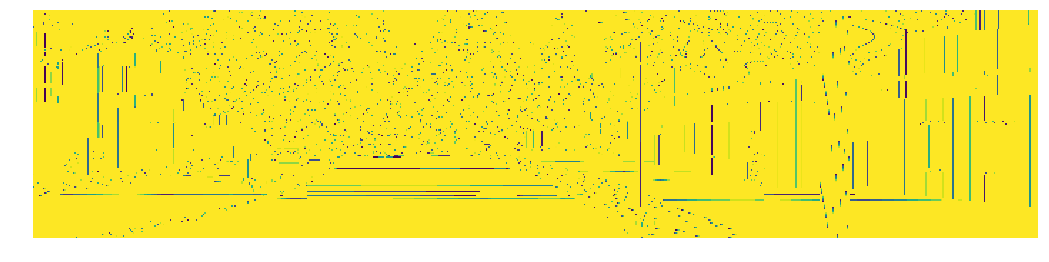

In [5]:
from data import get_depth

# Depth image
depth_image = cv2.imread(str(train_set.depths[index], encoding='utf-8'), cv2.IMREAD_COLOR)
depth_image = get_depth(crop_image_cv2(depth_image, crop=train_set.img_resolution, crop_shift=0))
print(f"depth_image shape = {depth_image.shape}, dtype = {depth_image.dtype}")

plt.figure(figsize=(18, 8))
plt.imshow(depth_image);
plt.axis('off');

### Segmentation image

semantic_image shape = (160, 704), dtype = uint8


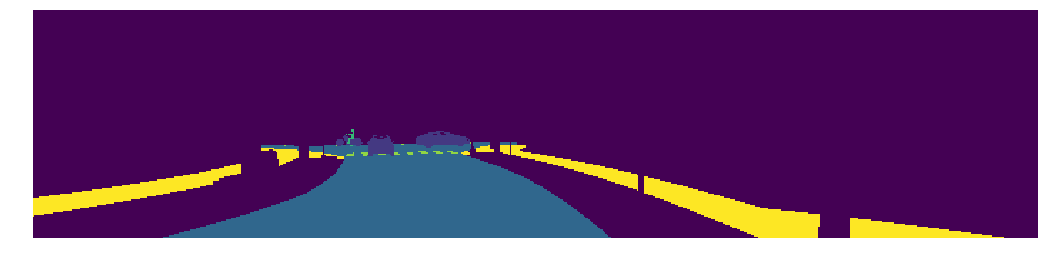

In [6]:
from data import crop_seg

# Semantic segmented image
semantic_image = cv2.imread(str(train_set.semantics[index], encoding='utf-8'), cv2.IMREAD_UNCHANGED)
semantic_image = train_set.converter[crop_seg(semantic_image, crop=train_set.img_resolution, crop_shift=0)]
print(f"semantic_image shape = {semantic_image.shape}, dtype = {semantic_image.dtype}")

plt.figure(figsize=(18, 8))
plt.imshow(semantic_image);
plt.axis('off');

### Ego vehicle measurement data

In [7]:
# Ego vehicle measurements
with open(str(train_set.measurements[index], encoding='utf-8'), 'r') as f1:
    measurements = ujson.load(f1)

data = {}
for k in ['steer', 'throttle', 'brake', 'speed', 'theta', 'x_command', 'y_command']:
    data[k] = measurements[k]
data['light'] = measurements['light_hazard']

In [8]:
data

{'steer': -0.035,
 'throttle': 0.75,
 'brake': False,
 'speed': 5.313167330369086e-07,
 'theta': 3.588655948638916,
 'x_command': 182.82735612929912,
 'y_command': 127.77637499105138,
 'light': False}

### Goal location (Command points)

In [9]:
# target points
# convert x_command, y_command to local coordinates
# taken from LBC code (uses 90+theta instead of theta)
ego_theta = measurements['theta']
ego_x = measurements['x']
ego_y = measurements['y']
x_command = measurements['x_command']
y_command = measurements['y_command']

R = np.array([
    [np.cos(np.pi/2+ego_theta), -np.sin(np.pi/2+ego_theta)],
    [np.sin(np.pi/2+ego_theta),  np.cos(np.pi/2+ego_theta)]
    ])
local_command_point = np.array([x_command-ego_x, y_command-ego_y])
local_command_point = R.T.dot(local_command_point)

print(f"ego_x = {ego_x : .3f}, ego_y = {ego_y: .3f}, x_command = {x_command: .3f}, y_command = {y_command: .3f}")
print(f"local_command_point = {local_command_point}")

ego_x =  212.865, ego_y =  134.020, x_command =  182.827, y_command =  127.776
local_command_point = [ -7.3558 -29.7853]


Instead of directly feeding in the target point, we'll plot the destination coordintes in BEV frame and provide it as input

Target point in lidar shape = (1, 256, 256)


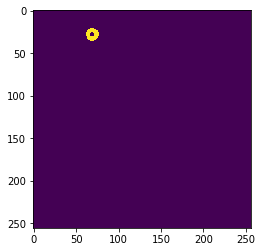

In [10]:
from data import draw_target_point
tgt_pt_in_lidar = draw_target_point(local_command_point)
print(f"Target point in lidar shape = {tgt_pt_in_lidar.shape}")
plt.imshow(tgt_pt_in_lidar[0]);

### Lidar Point Cloud

Lidar point cloud shape = (32377, 4)
below shape = (17369, 4), above shape = (15008, 4)


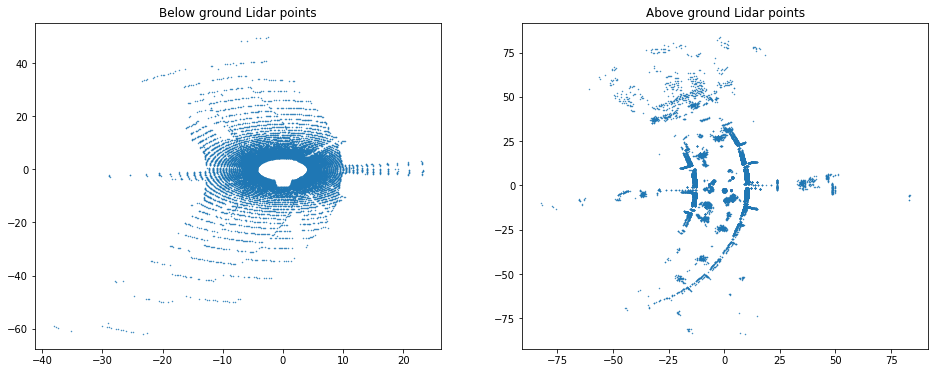

In [11]:
# load point cloud (XYZI), flip y-axis, compute Lidar BEV features
lidars_pc = np.load(str(train_set.lidars[index], encoding='utf-8'), allow_pickle=True)[1] 
lidars_pc[:, 1] *= -1
print(f"Lidar point cloud shape = {lidars_pc.shape}")

# filter points above and below ground
below = lidars_pc[lidars_pc[...,2]<=-2.3]
above = lidars_pc[lidars_pc[...,2]>-2.3]
print(f"below shape = {below.shape}, above shape = {above.shape}")

fig, ax  = plt.subplots(1,2, figsize=(16,6))
ax[0].scatter(-below[:,0], -below[:,1], s = 0.2);
ax[0].set_title("Below ground Lidar points");
ax[1].scatter(-above[:,0], -above[:,1], s = 0.2);
ax[1].set_title("Above ground Lidar points");

The lidar point cloud from simulator covers 360 degree for larger range (distance). We'll crop the points within BEV range (32m x32m)

Lidar histogram feature shape = (2, 256, 256)


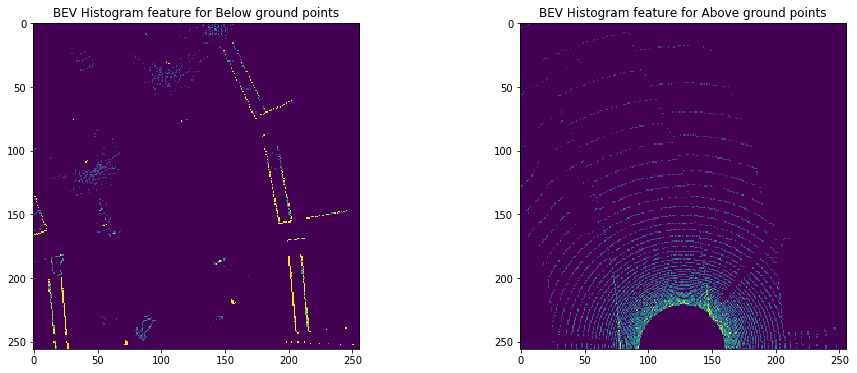

In [12]:
# generate BEV histogram featuers, separately for
# above ground and below ground points
from data import lidar_to_histogram_features
lidars_pc = lidar_to_histogram_features(lidars_pc)
print(f"Lidar histogram feature shape = {lidars_pc.shape}")

fig, ax  = plt.subplots(1,2, figsize=(16,6))
ax[0].imshow(lidars_pc[0]);
ax[0].set_title("BEV Histogram feature for Below ground points");
ax[1].imshow(lidars_pc[1]);
ax[1].set_title("BEV Histogram feature for Above ground points");

Apart from sensor inputs, we can consider Bounding boxes of objects in environment, which can be used as an auxiliary target, to improve training performance

### BEV Bounding Boxes

Bounding boxes are represented by 2D rectangles, with **[centre x, centre y, width, height, yaw]** representation. Additionally, we add the brake and speed information for each agent

In [13]:
# Because the strings are stored as numpy byte objects we need to convert them back to utf-8 strings
# Since we also load labels for future timesteps, we load and store them separately
labels = []
for i in range(train_set.seq_len + train_set.pred_len):
    with open(str(train_set.labels[index][i], encoding='utf-8'), 'r') as f2:
        labels_i = ujson.load(f2)
    labels.append(labels_i)
    
from pprint import pprint
pprint(labels[0][0])

{'brake': 0.0,
 'class': 'Car',
 'distance': -1,
 'ego_matrix': [[-0.4323187470436096,
                 -0.9017208814620972,
                 2.5911156171787297e-06,
                 134.02020263671875],
                [0.9017208814620972,
                 -0.4323187470436096,
                 -4.763479637404089e-07,
                 -212.85562133789062],
                [1.5497206504733185e-06,
                 2.130528628185857e-06,
                 1.0,
                 0.07165290415287018],
                [0.0, 0.0, 0.0, 1.0]],
 'extent': [1.5107464790344238, 4.901683330535889, 2.128324270248413],
 'id': 7022,
 'num_points': -1,
 'position': [-1.3, 0.0, -2.5],
 'speed': 5.313167330369086e-07,
 'yaw': 0}


Here `ego_matrix` contains the agent position in Global CARLA coordinates. `extent` is 3D Bounding box information

In [15]:
# Bounding boxes of objects within BEV FOV(32m x 32m)
# considering only current frame objects
from data import parse_labels
bboxes = parse_labels(labels[0])
label = np.array(list(bboxes.values()))
print(f"Label shape = {label.shape}")
print(label)

Label shape = (1, 7)
[[36.727  23.5047 14.7609 29.067  -3.5458  0.      0.    ]]


### Future Ego waypoints

ego_waypoints shape = (4, 2)
[[-1.3    -0.    ]
 [-1.3    -0.    ]
 [-0.9311 -0.0094]
 [ 0.9653 -0.0805]]


Text(0.5, 1.0, 'Ego vehicle future waypoints')

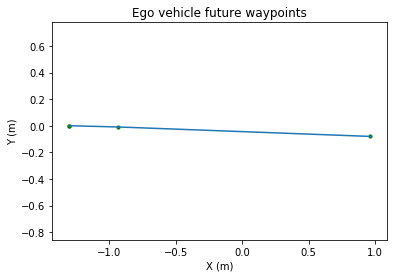

In [25]:
# ego car is always the first one in label file
ego_id = labels[0][0]['id']

# use position of ego vehicle in future frames
# as groundtruth reference
from data import get_waypoints, transform_waypoints
waypoints = get_waypoints(labels[train_set.seq_len-1:], train_set.pred_len+1)
waypoints = transform_waypoints(waypoints)
ego_waypoints = np.array([x[0][:2,3] for x in waypoints[ego_id][1:]])
print(f"ego_waypoints shape = {ego_waypoints.shape}")
print(ego_waypoints)

plt.plot(ego_waypoints[:,0], ego_waypoints[:,1]);
plt.scatter(ego_waypoints[:,0], ego_waypoints[:,1], s = 10, color='g');
plt.axis('equal')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Ego vehicle future waypoints')

To summarise, for each frame, we havethe following inputs:

--- | --- | ---
Name | Shape | Description

- RGB Image (160, 704, 3)
- Depth Image (160, 704) float 64
- Semantic Image (160, 704)
- Local command points (N,2) in ego vehicle coordinates
- Local command point image (1, 256, 256)
- BEV Lidar histogram feature image (2, 256, 256)
- BEV Bounding Boxes (N, 7) [centre x, centre y, width, height, yaw, speed, brake] in BEV frame
- Target waypoints (N, 2) Future ego vehicle coordinates w.r.t current frame